In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats

df = pd.read_csv("audible_cleaned.csv")

# Clean the price column by removing commas
df["price"] = df["price"].str.replace(",", "")
df["price"] = df["price"].str.replace("$", "")
df["price"] = df["price"].str.replace("Free", "0")
df["price"] = df["price"].astype(float)


# Convert releasedate to datetime
df["releasedate"] = pd.to_datetime(df["releasedate"])
df["release_year"] = df["releasedate"].dt.year


# Basic statistics for numerical columns
numeric_cols = ["time", "stars", "price", "ratings"]
desc_stats = df[numeric_cols].describe()
print("\nBasic Statistics:")
print(desc_stats)

# Calculate additional statistics
print("\nAdditional Statistics:")
for col in numeric_cols:
    print(f"\n{col}:")
    data_series = df[col]

    # Mode
    mode_value = data_series.mode()[0]
    print(f"Mode: {mode_value}")

    # Skewness and Kurtosis
    skew = data_series.skew()
    kurt = data_series.kurtosis()
    print(f"Skewness: {skew:.2f}")
    print(f"Kurtosis: {kurt:.2f}")

    # Quartiles and IQR
    q1 = data_series.quantile(0.25)
    q3 = data_series.quantile(0.75)
    iqr = q3 - q1
    print(f"Q1 (25th percentile): {q1}")
    print(f"Q3 (75th percentile): {q3}")
    print(f"Interquartile Range (IQR): {iqr}")

    # Range
    data_range = data_series.max() - data_series.min()
    print(f"Range: {data_range}")

# Author frequency
print("\nAuthor Frequency:")
author_counts = df["author"].value_counts()
print(author_counts)

# Correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = df[numeric_cols].corr()
print(correlation_matrix)


========== DESCRIPTIVE STATISTICS ==========

Basic Statistics:
               time        stars         price       ratings
count  15072.000000  15072.00000  15072.000000  15072.000000
mean     549.968617      4.45694    689.512666     14.318206
std      446.706118      0.72394    326.821215     55.785925
min        1.000000      1.00000      0.000000      1.000000
25%      301.000000      4.00000    500.000000      1.000000
50%      476.000000      4.50000    668.000000      2.000000
75%      673.000000      5.00000    879.000000      7.000000
max     8595.000000      5.00000   3416.000000    985.000000

Additional Statistics:

time:
Mode: 417
Skewness: 3.84
Kurtosis: 30.75
Q1 (25th percentile): 301.0
Q3 (75th percentile): 673.0
Interquartile Range (IQR): 372.0
Range: 8594

stars:
Mode: 5.0
Skewness: -2.14
Kurtosis: 5.99
Q1 (25th percentile): 4.0
Q3 (75th percentile): 5.0
Interquartile Range (IQR): 1.0
Range: 4.0

price:
Mode: 668.0
Skewness: 0.54
Kurtosis: 1.79
Q1 (25th percentile):

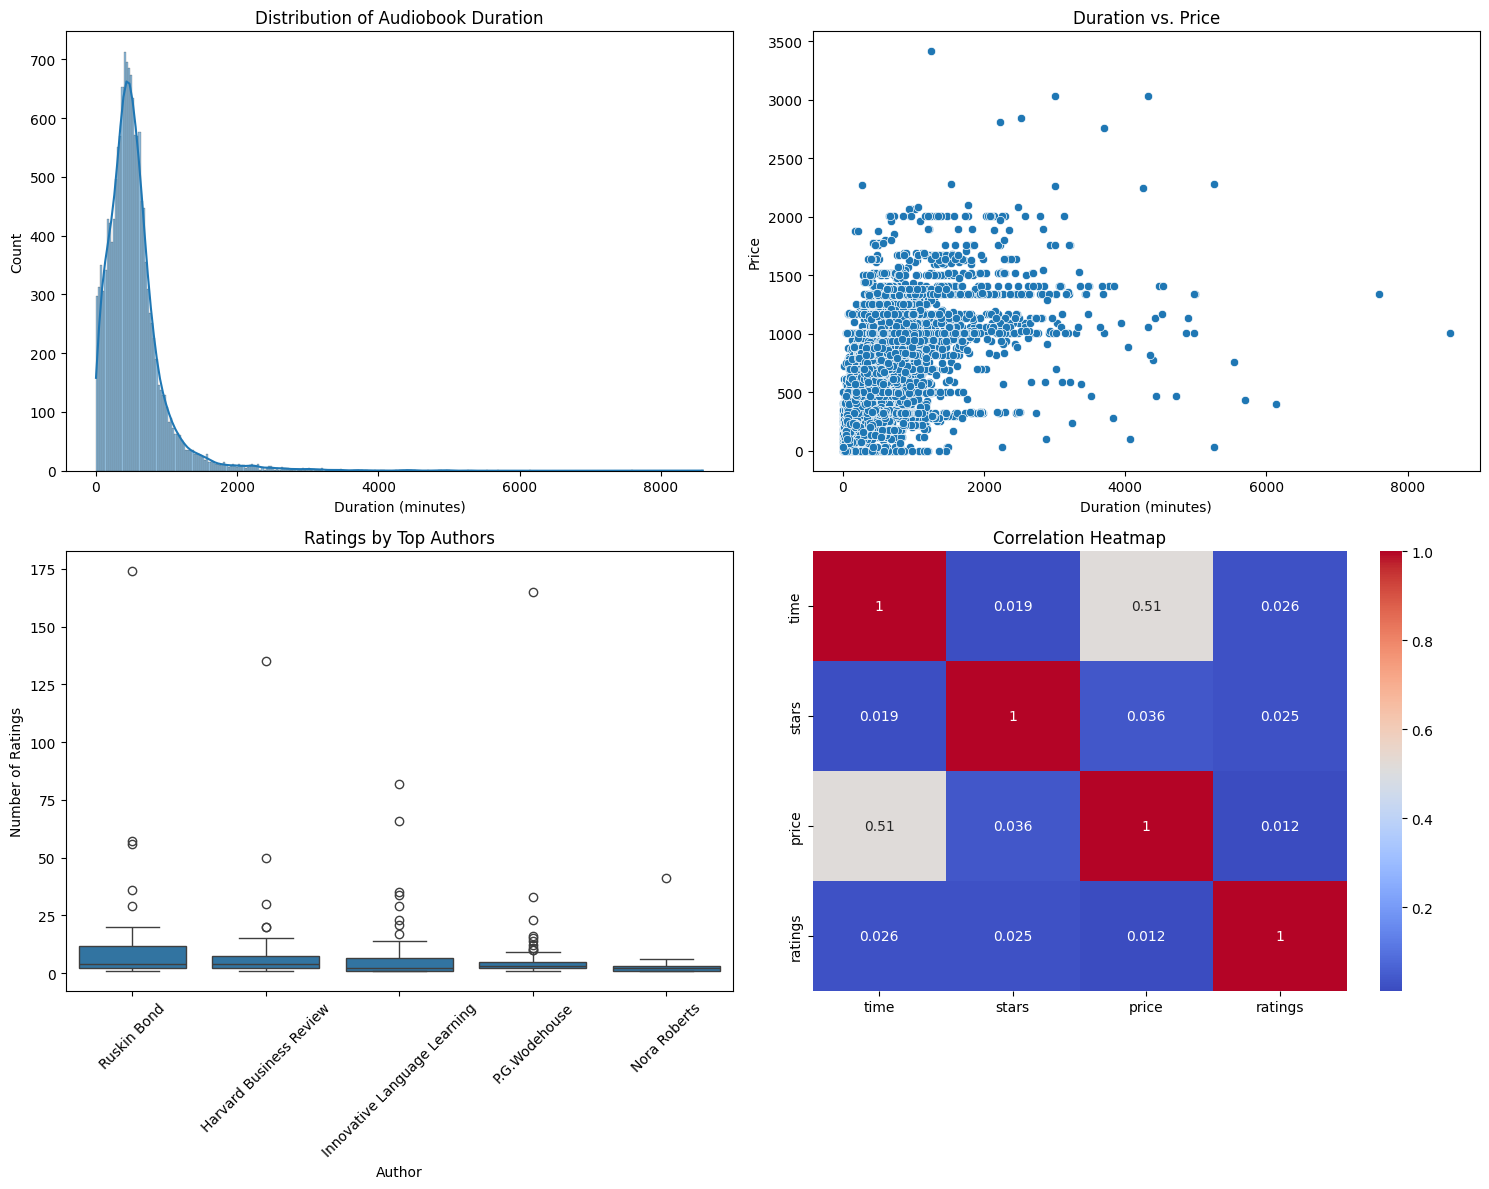

In [14]:
# Part 2: Visualizations (commented out for demonstration)
# Create a figure with multiple subplots
plt.figure(figsize=(15, 12))

# Histogram of time duration
plt.subplot(2, 2, 1)
sns.histplot(df['time'], kde=True)
plt.title('Distribution of Audiobook Duration')
plt.xlabel('Duration (minutes)')

# Scatter plot of time vs. price
plt.subplot(2, 2, 2)
sns.scatterplot(x='time', y='price', data=df)
plt.title('Duration vs. Price')
plt.xlabel('Duration (minutes)')
plt.ylabel('Price')

# Boxplot of ratings by author (top 5 authors)
plt.subplot(2, 2, 3)
top_authors = author_counts.head(5).index
sns.boxplot(x='author', y='ratings', data=df[df['author'].isin(top_authors)])
plt.title('Ratings by Top Authors')
plt.xticks(rotation=45)
plt.xlabel('Author')
plt.ylabel('Number of Ratings')

# Correlation heatmap
plt.subplot(2, 2, 4)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [ ]:
print("\n========== GRANGER CAUSALITY ANALYSIS ==========")
df_sorted = df.sort_values("releasedate")
yearly_data = (
    df.groupby("release_year")
    .agg({"time": "mean", "price": "mean", "ratings": "mean", "stars": "mean"})
    .reset_index()
)
time_series_data = yearly_data[["time", "price", "ratings"]].values

def test_granger_causality(data, variables, max_lag=2):
    n_variables = len(variables)
    results = {}
    for i in range(n_variables):
        for j in range(n_variables):
            if i != j:
                y = data[:, i]
                x = data[:, j]
                pair_data = np.column_stack([y, x])
                test_result = grangercausalitytests(
                    pair_data, maxlag=max_lag, verbose=False
                )
                p_values = [
                    test_result[lag + 1][0]["ssr_ftest"][1] for lag in range(max_lag)
                ]
                causality = any(p < 0.05 for p in p_values)
                pair_name = f"{variables[j]} → {variables[i]}"
                results[pair_name] = {"p_values": p_values, "causality": causality}
    return results

variables = ["time", "price", "ratings"]
granger_results = test_granger_causality(time_series_data, variables, max_lag=1)
print("\nGranger Causality Test Results (α = 0.05):")

for pair, result in granger_results.items():
    causality_string = (
        "DOES Granger-cause" if result["causality"] else "does NOT Granger-cause"
    )
    p_values_str = ", ".join([f"{p:.4f}" for p in result["p_values"]])
    print(f"{pair}: {causality_string} (p-values: {p_values_str})")

print("\nInterpretation Example:")
print(
    """
The Granger causality test examines whether past values of one variable (X) help predict
future values of another variable (Y) beyond what past values of Y alone would predict.
Interpretation rules:
- If p-value < 0.05: We reject the null hypothesis and conclude that X Granger-causes Y
- If p-value ≥ 0.05: We fail to reject the null hypothesis, meaning X does not Granger-cause Y
Note: Granger causality does not necessarily imply true causality. It only suggests
predictive causality (temporal precedence in information).
For audiobooks, we might investigate questions like:
- Does audiobook length (time) Granger-cause price?
- Does price Granger-cause ratings?
- Does the number of ratings Granger-cause future pricing decisions?
"""
)
print("\nReal-World Example with Our Data:")
print(
    """
Based on our Granger causality results, we can examine whether:
1. Audiobook duration influences pricing decisions by publishers
2. Pricing influences customer ratings
3. Customer ratings influence future audiobook durations
"""
)
highlight_pair = next(
    (pair for pair in granger_results if "price → ratings" in pair), None
)
if highlight_pair:
    result = granger_results[highlight_pair]
    if result["causality"]:
        print(
            f"\nInteresting finding: {highlight_pair} with p-value {result['p_values'][0]:.4f}"
        )
        print(
            "This suggests that audiobook pricing may have a temporal influence on ratings."
        )
        print(
            "Publishers might want to consider how pricing strategies affect customer satisfaction."
        )
    else:
        print(
            f"\nInteresting finding: {highlight_pair} with p-value {result['p_values'][0]:.4f}"
        )
        print(
            "This suggests that audiobook pricing does not temporally influence ratings."
        )
        print("Customers may rate books based on content quality rather than price.")


========== GRANGER CAUSALITY ANALYSIS ==========

Granger Causality Test Results (α = 0.05):
price → time: does NOT Granger-cause (p-values: 0.4429)
ratings → time: DOES Granger-cause (p-values: 0.0030)
time → price: DOES Granger-cause (p-values: 0.0106)
ratings → price: DOES Granger-cause (p-values: 0.0007)
time → ratings: does NOT Granger-cause (p-values: 0.4595)
price → ratings: does NOT Granger-cause (p-values: 0.6728)

Interpretation Example:

The Granger causality test examines whether past values of one variable (X) help predict
future values of another variable (Y) beyond what past values of Y alone would predict.

Interpretation rules:
- If p-value < 0.05: We reject the null hypothesis and conclude that X Granger-causes Y
- If p-value ≥ 0.05: We fail to reject the null hypothesis, meaning X does not Granger-cause Y

Note: Granger causality does not necessarily imply true causality. It only suggests
predictive causality (temporal precedence in information).

For audiobooks, we

/Users/uncool/Library/Caches/pypoetry/virtualenvs/trest-oJEZBxX2-py3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
